In [1]:
import pkg_resources
import subprocess, sys

In [2]:
# First upgrade the environment.
import pip
from subprocess import run
# add & upgrade what you will need
modules =[
    'pandas_market_calendars',
    'plotly', 
    'numpy',
    'sklearn',
    'pandas',
    'matplotlib'
]
proc = run(f'pip install {" ".join(modules)} --upgrade --no-input', 
       shell=True, 
       text=True, 
       capture_output=True, 
       timeout=120) #a couple of minutes
print(proc.stderr)

/opt/conda/lib/python3.9/site-packages/_distutils_hack/__init__.py:30: UserWarning: Setuptools is replacing distutils.
  warnings.warn("Setuptools is replacing distutils.")


In [3]:
sp = subprocess.run([sys.executable, '--version'], capture_output=True)
print(sys.executable)
print(sp.stdout.strip().decode("utf-8"))

/opt/conda/bin/python
Python 3.9.10


In [4]:
import pandas as pd
from pathlib import Path
import numpy as np
import datetime as dt

import matplotlib
import matplotlib.pyplot as plt
from matplotlib.ticker import ScalarFormatter, FuncFormatter, StrMethodFormatter
%matplotlib inline

import plotly as ply
import plotly.graph_objects as go

import sklearn
from sklearn.preprocessing import StandardScaler, Normalizer
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import TimeSeriesSplit

from functools import reduce
from operator import mul
from pprint import PrettyPrinter
pprint = PrettyPrinter().pprint

In [5]:
#Reading data from cscv file and resetting index as datetime.
df=pd.read_csv("https://people.arcada.fi/~parland/hjd5_8amp_Gt3/EURUSD1m.zip", index_col='Date',parse_dates=True)
df.head()

,Timestamp,Open,High,Low,Close,Volume
Date,,,,,,
2010-01-01,11:00:00,1.43327,1.43335,1.43319,1.43335,56.299999
2010-01-01,11:01:00,1.43333,1.43333,1.43318,1.43327,82.100001
2010-01-01,11:02:00,1.43328,1.43333,1.43319,1.43333,86.900000
2010-01-01,11:03:00,1.43325,1.43333,1.43319,1.43326,68.899999
2010-01-01,11:04:00,1.43326,1.43333,1.43319,1.43319,45.300000


In [6]:
#Checking index type.
type(df.index)

pandas.core.indexes.datetimes.DatetimeIndex

In [7]:
#Resampling dataframe to 1 day step.
Rdf=df.resample(rule='D').mean()
Rdf.head(10)

/tmp/ipykernel_255/1798352873.py:2: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  Rdf=df.resample(rule='D').mean()


,Open,High,Low,Close,Volume
Date,,,,,
2010-01-01,1.433194,1.433288,1.433089,1.433178,60.243939
2010-01-02,NaN,NaN,NaN,NaN,NaN
2010-01-03,1.431891,1.432094,1.431711,1.431913,25.013333
2010-01-04,1.436431,1.436693,1.436159,1.436451,55.569028
2010-01-05,1.440870,1.441108,1.440588,1.440881,55.477153
2010-01-06,1.436875,1.437116,1.436592,1.436898,56.230417
2010-01-07,1.435212,1.435446,1.434926,1.435225,56.116320
2010-01-08,1.433802,1.434065,1.433514,1.433824,57.691212
2010-01-09,NaN,NaN,NaN,NaN,NaN


In [8]:
# Removing all rows with all NaN values
Rdf = Rdf.dropna(how='all')
#Checking if there are any NaN values left
Rdf[Rdf.isna().all(axis=1)].count()

Open      0
High      0
Low       0
Close     0
Volume    0
dtype: int64

In [9]:
#creating Label
Rdf = Rdf.assign(Label=Rdf.Close.shift(-1))
Rdf

,Open,High,Low,Close,Volume,Label
Date,,,,,,
2010-01-01,1.433194,1.433288,1.433089,1.433178,60.243939,1.431913
2010-01-03,1.431891,1.432094,1.431711,1.431913,25.013333,1.436451
2010-01-04,1.436431,1.436693,1.436159,1.436451,55.569028,1.440881
2010-01-05,1.440870,1.441108,1.440588,1.440881,55.477153,1.436898
2010-01-06,1.436875,1.437116,1.436592,1.436898,56.230417,1.435225
...,...,...,...,...,...,...
2019-12-26,1.109451,1.109475,1.109429,1.109451,36.627798,1.114452
2019-12-27,1.114447,1.114498,1.114401,1.114452,94.375684,1.117858
2019-12-29,1.117864,1.117915,1.117801,1.117858,27.491448,1.119915


In [10]:
# Removing last row as it contains NaN value
Rdf=Rdf.drop('2019-12-31')
Rdf

,Open,High,Low,Close,Volume,Label
Date,,,,,,
2010-01-01,1.433194,1.433288,1.433089,1.433178,60.243939,1.431913
2010-01-03,1.431891,1.432094,1.431711,1.431913,25.013333,1.436451
2010-01-04,1.436431,1.436693,1.436159,1.436451,55.569028,1.440881
2010-01-05,1.440870,1.441108,1.440588,1.440881,55.477153,1.436898
2010-01-06,1.436875,1.437116,1.436592,1.436898,56.230417,1.435225
...,...,...,...,...,...,...
2019-12-25,1.108536,1.108557,1.108512,1.108536,8.440950,1.109451
2019-12-26,1.109451,1.109475,1.109429,1.109451,36.627798,1.114452
2019-12-27,1.114447,1.114498,1.114401,1.114452,94.375684,1.117858


In [11]:
# Define a function for calculating Larry williams R% indicator.
def get_wr(High, Low, Close, lookback):
    highh = High.rolling(lookback).max() 
    lowl = Low.rolling(lookback).min()
    wr = -100 * ((highh - Close) / (highh - lowl))
    return wr

Rdf['wr_14'] = get_wr(Rdf['High'], Rdf['Low'], Rdf['Close'], 14)
Rdf

,Open,High,Low,Close,Volume,Label,wr_14
Date,,,,,,,
2010-01-01,1.433194,1.433288,1.433089,1.433178,60.243939,1.431913,NaN
2010-01-03,1.431891,1.432094,1.431711,1.431913,25.013333,1.436451,NaN
2010-01-04,1.436431,1.436693,1.436159,1.436451,55.569028,1.440881,NaN
2010-01-05,1.440870,1.441108,1.440588,1.440881,55.477153,1.436898,NaN
2010-01-06,1.436875,1.437116,1.436592,1.436898,56.230417,1.435225,NaN
...,...,...,...,...,...,...,...
2019-12-25,1.108536,1.108557,1.108512,1.108536,8.440950,1.109451,-91.632507
2019-12-26,1.109451,1.109475,1.109429,1.109451,36.627798,1.114452,-80.195227
2019-12-27,1.114447,1.114498,1.114401,1.114452,94.375684,1.117858,-17.202647


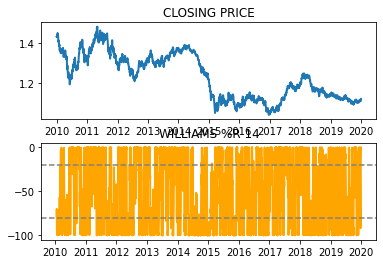

In [12]:
# Plotting Larry williams %R technical analysis indicator.
ax1 = plt.subplot2grid((11,1), (0,0), rowspan = 5, colspan = 1)
ax2 = plt.subplot2grid((11,1), (6,0), rowspan = 5, colspan = 1)
ax1.plot(Rdf['Close'], linewidth = 2)
ax1.set_title('CLOSING PRICE')
ax2.plot(Rdf['wr_14'], color = 'orange', linewidth = 2)
ax2.axhline(-20, linewidth = 1.5, linestyle = '--', color = 'grey')
ax2.axhline(-80, linewidth = 1.5, linestyle = '--', color = 'grey')
ax2.set_title('WILLIAMS %R 14')
plt.show()

In [13]:
#Dropping other columns of dataframe other than Close and Label for test train split.
Rdf1 = Rdf[['Close','Label']].copy()
Rdf1

,Close,Label
Date,,
2010-01-01,1.433178,1.431913
2010-01-03,1.431913,1.436451
2010-01-04,1.436451,1.440881
2010-01-05,1.440881,1.436898
2010-01-06,1.436898,1.435225
...,...,...
2019-12-25,1.108536,1.109451
2019-12-26,1.109451,1.114452
2019-12-27,1.114452,1.117858


In [14]:
# splitting data into 80, 20 subsets
sklearn.model_selection.train_test_split
from sklearn.model_selection import TimeSeriesSplit
tss=TimeSeriesSplit(n_splits=5)
x=Rdf1.drop(labels=['Label'], axis=1)
y=Rdf1['Label']
for train_index, test_index in tss.split(x):
    x_train, x_test=x.iloc[train_index,:], x.iloc[test_index,:]
    y_train, y_test=y.iloc[train_index], y.iloc[test_index]
x_train.info()
y_train.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 2606 entries, 2010-01-01 to 2018-05-01
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Close   2606 non-null   float64
dtypes: float64(1)
memory usage: 40.7 KB
<class 'pandas.core.series.Series'>
DatetimeIndex: 2606 entries, 2010-01-01 to 2018-05-01
Series name: Label
Non-Null Count  Dtype  
--------------  -----  
2606 non-null   float64
dtypes: float64(1)
memory usage: 40.7 KB


<AxesSubplot: xlabel='Date'>

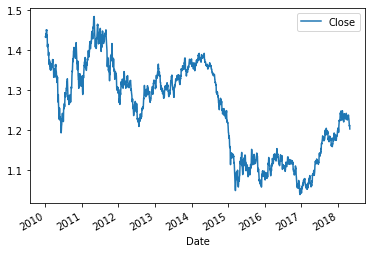

In [15]:
x_train.plot()

In [16]:
# standardize data using standard scaler
scaler = StandardScaler()
print(scaler.fit(Rdf1))
StandardScaler()
print(scaler.mean_)
print(scaler.transform(Rdf1))

StandardScaler()
[1.23099945 1.23089958]
[[ 1.78453623  1.7748893 ]
 [ 1.77337134  1.81495675]
 [ 1.81342442  1.854072  ]
 ...
 [-1.02871348 -0.99812719]
 [-0.99865086 -0.97995589]
 [-0.98048608 -0.97156507]]


In [17]:
# Fitting a linear model to training data
from sklearn.linear_model import LinearRegression
model= LinearRegression()
model.fit(x_train, y_train)
R_train=model.score(x_train, y_train)
R_test=model.score(x_test, y_test)
print("\nR2 for train data is", R_train)
print("\nR2 for test data is", R_test)


R2 for train data is 0.9978598904703156

R2 for test data is 0.9850765209885048


In [18]:
# First five predictions based on test data
predictions= model.predict(x_test)
predictions[:5]

array([1.19860392, 1.19818025, 1.19657976, 1.19594645, 1.19343823])

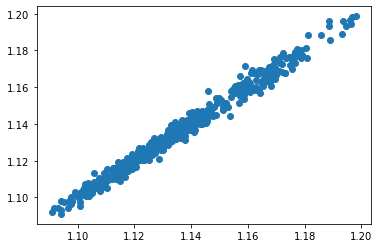

In [19]:
## The line / model
plt.scatter(y_test, predictions)
# model is 98% accurate.

In [20]:
#Grade 2

In [21]:
#stochastic %D
def get_SlowD(High, Low, Close, lookback):
        H = High.rolling(lookback).max()
        L = Low.rolling(lookback).min()
        SlowD  = 100 * ((Close - L) / (H - L))
        return SlowD

Rdf['Slow_D'] = get_SlowD(Rdf['High'], Rdf['Low'], Rdf['Close'], 14)
Rdf= Rdf.dropna()
Rdf.head()

,Open,High,Low,Close,Volume,Label,wr_14,Slow_D
Date,,,,,,,,
2010-01-17,1.436004,1.436192,1.435818,1.436037,33.940000,1.437643,-78.123082,21.876918
2010-01-18,1.437623,1.437833,1.437363,1.437643,55.667292,1.433312,-70.001061,29.998939
2010-01-19,1.433307,1.433536,1.433012,1.433312,54.864653,1.415886,-98.375239,1.624761
2010-01-20,1.415888,1.416130,1.415571,1.415886,55.764236,1.408648,-99.121979,0.878021
2010-01-21,1.408639,1.408899,1.408316,1.408648,54.847292,1.413203,-99.230763,0.769237


In [22]:
#Filtering test data from Dataframe before test training 
#retrieving Open, High, Low, columns for creating OHLC figure.
test_data=Rdf.loc['2018-05-02':'2019-12-30']
test_data

,Open,High,Low,Close,Volume,Label,wr_14,Slow_D
Date,,,,,,,,
2018-05-02,1.198619,1.198722,1.198513,1.198615,188.944605,1.198191,-99.738150,0.261850
2018-05-03,1.198188,1.198292,1.198092,1.198191,182.249633,1.196588,-99.750206,0.249794
2018-05-04,1.196591,1.196688,1.196495,1.196588,164.922398,1.195954,-99.768288,0.231712
2018-05-06,1.195955,1.195995,1.195917,1.195954,36.409106,1.193442,-99.894679,0.105321
2018-05-07,1.193444,1.193520,1.193366,1.193442,139.359702,1.188623,-99.783302,0.216698
...,...,...,...,...,...,...,...,...
2019-12-25,1.108536,1.108557,1.108512,1.108536,8.440950,1.109451,-91.632507,8.367493
2019-12-26,1.109451,1.109475,1.109429,1.109451,36.627798,1.114452,-80.195227,19.804773
2019-12-27,1.114447,1.114498,1.114401,1.114452,94.375684,1.117858,-17.202647,82.797353


In [23]:
import plotly.offline as pyo
pyo.init_notebook_mode(connected=True)
pd.options.plotting.backend = 'plotly'

from plotly.subplots import make_subplots

In [24]:
#Adding subplot(s) with the LW%R and Stochastic slow %D features

fig = make_subplots(rows=3, cols=1,
                    shared_xaxes=True,
                    vertical_spacing=0.04,
                    subplot_titles=('OHLC', 'LarryWilliams-R%', 'Stochastic-Slow-%D'),
                    specs=[[{"secondary_y": True}], [{"secondary_y": True}],[{"secondary_y": True},]])

fig.add_trace(go.Ohlc(
            x=test_data.index,
            open=test_data['Open'],
            high=test_data['High'],
            low=test_data['Low'],
            close=test_data['Close'],
            name="OHLC"),
            row=1, col=1)

fig.add_trace(go.Scatter(
            x=x_test.index,
            y=predictions,
            name="Forecast (Predicted Value)",
            line_color='#ffe476'),
            row=1, col=1)

fig.add_trace(go.Scatter(
            x=x_test.index,
            y=y_test,
            name="Label (Actual Data)",
            line_color='#8A360F'),
            row=1, col=1)

fig.add_trace(go.Scatter(   
            x=Rdf.index,
            y=Rdf['wr_14'],
            name="larryWilliams-R%"),
            row=2, col=1
)

fig.add_trace(go.Scatter(
            x=Rdf.index,
            y=Rdf['Slow_D'],
            name="Stochastic-slow-%D"),
            row=3, col=1
)

fig.update_layout(   
            height=800,
            width=1000,
            title_text="Stock OHLC, LarryWilliam, Stochastic-slow-%D, Subplots on Train Data",
)

fig.update(layout_xaxis_rangeslider_visible=False)
fig.show()

KeyError: 'rsi'

In [ ]:
# Stochastic slow% D is above 80. It shows that stock is overbought. 

In [ ]:
# Calculating RSI
delta = Rdf['Close'].diff() 
up = delta.clip(lower=0)
down = -1*delta.clip(upper=0)
ema_up = up.ewm(com=13, adjust=False).mean()
ema_down = down.ewm(com=13, adjust=False).mean()
rsi = ema_up/ema_down
print(Rdf)

In [ ]:
#importing directories
from sklearn.linear_model import ElasticNet
from sklearn.metrics import mean_squared_error,r2_score
from sklearn.model_selection import cross_val_score

In [ ]:
#Fitting ElasticNet model to train data
enet_model = ElasticNet().fit(x_train, y_train)
enet_model.predict(x_train)[:10]

In [ ]:
enet_model.predict(x_test)[:10]

In [ ]:
y_pred = enet_model.predict(x_test)
np.sqrt(mean_squared_error(y_test,y_pred))

In [ ]:
r2_score(y_test,y_pred) # Calculating R2 for test data

In [ ]:
x_pred = enet_model.predict(x_train)
np.sqrt(mean_squared_error(x_train,x_pred))

In [ ]:
r2_score(x_train,x_pred) # Calculating R2 for train data

In [ ]:
Rdf_y_pred= pd.concat([y_train.reset_index(drop=True), pd.DataFrame(y_pred,columns = ['y_pred'])], axis=1)
Rdf_y_pred

In [ ]:
#grade 4